In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

outputdir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/23_diurnal_cycle/"

###################################################
# Data cloudnet:

cloudnet_path = "/home/qwertz/obs_data_MA/iqq_cloudnet/"
files = ["20180822_iquique_classification.nc","20180823_iquique_classification.nc",\
         "20180822_iquique_halo-doppler-lidar_BL-classification.nc", "20180823_iquique_halo-doppler-lidar_BL-classification.nc",\
         "20180822_iquique_halo-doppler-lidar_cloud.nc", "20180823_iquique_halo-doppler-lidar_cloud.nc",\
         "20180822_iquique_lwc-adiabatic-method.nc", "20180823_iquique_lwc-adiabatic-method.nc"]

ds_class22 = xr.open_dataset(cloudnet_path+files[0])
ds_class23 = xr.open_dataset(cloudnet_path+files[1])
ds_class = xr.concat([ds_class22, ds_class23], dim="time")
ds_bl22 = xr.open_dataset(cloudnet_path+files[2])
ds_bl23 = xr.open_dataset(cloudnet_path+files[3])
ds_bl = xr.concat([ds_bl22, ds_bl23], dim="time_3min")
ds_lidar22 = xr.open_dataset(cloudnet_path+files[4])
ds_lidar23 = xr.open_dataset(cloudnet_path+files[5])
ds_lidar = xr.concat([ds_lidar22, ds_lidar23], dim="time_3min")
ds_lwp22 = xr.open_dataset(cloudnet_path+files[6])
ds_lwp23 = xr.open_dataset(cloudnet_path+files[7])
ds_lwp = xr.concat([ds_lwp22, ds_lwp23], dim="time")

######################################################
# Data ICON:

file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
ds_icon = xr.open_dataset(file_icon)

######################################################
# LWP Foghat:

file2 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_clwvi_p00_20180822000000.nc"
file4 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_clwvi_p00_20180823000000.nc"
lwp_icon = ds_icon["tqc"].isel(ncells=0)
ds_foghat_cloud22 = xr.open_dataset(file2, engine="netcdf4")
ds_foghat_cloud23 = xr.open_dataset(file4, engine="netcdf4")
lwp_obs = xr.concat([ds_foghat_cloud22["clwvi"], ds_foghat_cloud23["clwvi"]], dim="time")


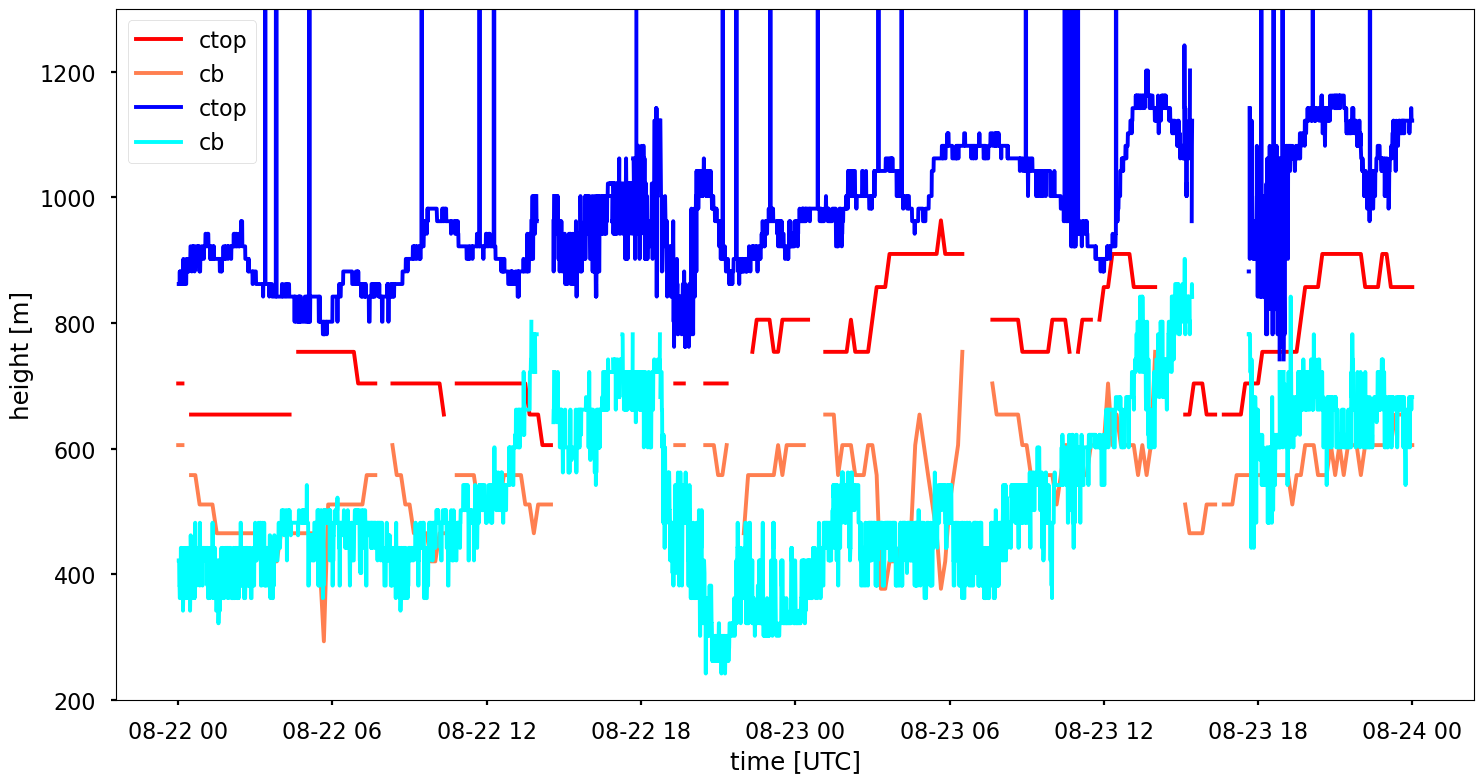

In [20]:
# 1st: detect cloudbase from ICON (see above)

import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_single_timestamp

#####################
# Pick timeslice:
# t_values = [20180822.0, 20180822.25, 20180822.5, 20180822.75, 20180823.0, 20180823.25, 20180823.5, 20180823.75, 20180824]
begin_float=20180822.0
end_float=20180824.0
datetime_begin = str(convert_single_timestamp(begin_float))[:19]
datetime_end = str(convert_single_timestamp(end_float))[:19]
    
ds_cb = ds_icon.isel(ncells=0).sel(time=slice(begin_float,end_float))
ds_class = ds_class.sel(time=slice(datetime_begin,datetime_end))

#####################

heights = ds_icon["z_mc"].isel(ncells=0).values
times = [convert_single_timestamp(date) for date in ds_cb["time"].values]

cloudbases_icon = []
cloudtops_icon = []
for i, timestep in enumerate(times):
    base_found = False
    top_found = False

    #print("\n\n",i, timestep, "\n")
    
    for j, height in enumerate(heights): 
        qc_value = ds_cb["qc"].values[i,j]
        if j > len(heights)-2:
            if not base_found:
                cloudbases_icon.append(np.nan)
                #print("base added1!!")
            if not top_found:
                cloudtops_icon.append(np.nan)
                #print("top added1!!!")
            break
            
        if qc_value>0 and ds_cb["qc"].values[i,j+1]>0 and ds_cb["qc"].values[i,j-1]==0 and ds_cb["qc"].values[i,j-2]==0 and not top_found:
            #print("first case (top): ",height)
            top_found = True
            cloudtops_icon.append(height)
            #print("base added2!!")
            
        elif qc_value==0 and ds_cb["qc"].values[i,j+1]==0 and ds_cb["qc"].values[i,j-1]>0 and ds_cb["qc"].values[i,j-2]>0 and not base_found:
            #print("second case (base): ",height)
            base_found = True
            cloudbases_icon.append(height)
            #print("top added2!!!")

#####################
# print(ds_cb)

plt.figure(figsize=(15,8))
plt.plot(times, cloudtops_icon, label="ctop", color="red")
plt.plot(times, cloudbases_icon, label="cb", color="coral")
# plt.xlabel("time [UTC]")
# plt.ylabel("height [m]")
# plt.legend()
# plt.tight_layout()

# plt.figure(figsize=(15,8))
plt.plot(ds_class["time"], ds_class["cloud_top_height"], label="ctop", color="blue")
plt.plot(ds_class["time"], ds_class["cloud_base_height"], label="cb", color="cyan")
plt.xlabel("time [UTC]")
plt.ylabel("height [m]")
plt.ylim(200,1300)
plt.legend()
plt.tight_layout()

In [17]:
# Diurnal cycle of ICON and Cloudnet data (cloudbase, cloud top, LWP):

# LWP:
ds_icon["time"]
ds_icon["tqc"]

print(ds_icon.data_vars)

print(ds_icon["tqc"])

Data variables:
    clon_bnds      (ncells, vertices) float32 12B ...
    clat_bnds      (ncells, vertices) float32 12B ...
    height_bnds    (height, bnds) float64 3kB ...
    height_3_bnds  (height_3, bnds) float64 3kB ...
    qv             (time, height, ncells) float32 250kB ...
    qc             (time, height, ncells) float32 250kB ...
    qi             (time, height, ncells) float32 250kB ...
    qr             (time, height, ncells) float32 250kB ...
    qs             (time, height, ncells) float32 250kB ...
    qg             (time, height, ncells) float32 250kB ...
    qh             (time, height, ncells) float32 250kB ...
    qnc            (time, height, ncells) float32 250kB ...
    qni            (time, height, ncells) float32 250kB ...
    qnr            (time, height, ncells) float32 250kB ...
    qns            (time, height, ncells) float32 250kB ...
    qng            (time, height, ncells) float32 250kB ...
    qnh            (time, height, ncells) float32 250k